In [1]:
import os

import numpy as np
import numpy.polynomial as poly
import networkx as nx
from tqdm import tqdm

import jax.numpy as jnp
import jax.random as random
from jax import grad, jit, vmap, lax, jacrev, jacfwd, jvp, vjp, hessian

In [2]:
import cellx as cx

In [3]:
@jit
def dE_swap(i, j, c, W):
    """
    Energy differential after swapping cells i and j.
    Depends only on i, j, and their neighbors
    """
    E_local       = W[c[(i, j), None], c[AL[(i, j),]]].sum()
    E_local_swap  = W[c[(j, i), None], c[AL[(i, j),]]].sum()
    
    return E_local - E_local_swap


@jit
def P_swap(dE, beta):
    """
    Probability of a swap between cells i and j. Symmetric w.r.t. i and j.
    """
    
    # Glauber dynamics probability
    # return 1 / (1 + jnp.exp(beta * dE))
    
    # Metropolis acceptance probability
    return jnp.minimum(1., jnp.exp(-beta * dE))

@jit
def H(c, W, AL):
    """Hamiltonian of the lattice-adhesion model."""
    return -W[c[:, None], c[AL]].sum()


@jit
def get_schedule(theta, t, poly_order, Cheb):
    temp_coeffs = jnp.dot(theta[:poly_order].T, Cheb)
    W11_coeffs  = jnp.dot(theta[-poly_order:].T, Cheb)
    temp_t = jnp.polyval(temp_coeffs, t)
    W11_t  = jnp.polyval(W11_coeffs, t)
    return temp_t, W11_t


@jit
def eval_W(W11):
    """Updates the W matrix"""
    return jnp.array([
        [W11, 0.0],
        [0.0, 0.0],
    ], dtype=jnp.float32)


@jit
def omega(theta, c_t, dE_t, t):
    """
    Entropy production produced by a parameterized schedule and observed 
    trajectory of cell swaps
    """
    temp_t, W11_t = get_schedule(theta, t)
    beta_t = 1 / temp_t
    return (
        beta_t[-1] * H(c_t[-1], eval_W(W11_t, -1), AL) \
        - beta_t[0] * H(c_t[0], eval_W(W11_t, 0), AL) \
        - jnp.dot(beta_t, dE_t)
    )


@jit
def swap_ij(c, i, j):
    """Swaps cells i and j in the cell type state vector `c`. """
    ci = c[i]
    cj = c[j]
    return c.at[i].set(cj).at[j].set(ci)


@jit
def take_MC_step(key, c, beta, AL, W):
    """
    Randomly selects a swap between adjacent cells and accepts/rejects based on 
    Glauber dynamics.
    """
    key, sk1, sk2 = random.split(key, 3)
    
    # Pick an interface from the adjacency list (AL)
    ij = random.randint(
        key=sk1, shape=(2,), minval=jnp.array([0, 0]), maxval=jnp.array(AL.shape)
    )
    i = ij[0]
    j = AL[ij[0], ij[1]]
    
    dE   = dE_swap(i, j, c, W)
    P_ij = P_swap(dE, beta)
    
    accept = jnp.array(P_ij > random.uniform(key=sk2), dtype=int)
    
    lnP = lax.cond(
        accept, 
        jnp.log, 
        lambda P: jnp.log(1 - P), 
        P_ij
    )
    c   = lax.cond(
        accept, 
        swap_ij, 
        lambda c, i, j: c, 
        c, 
        i, 
        j,
    )
    
    return key, c, i, j, dE, lnP, accept


@jit 
def lnP_traj(lnP_t):
    """Returns log-probability of a trajectory"""
    pass

@jit
def n_cmatch_t(c_t, AL):
    """Returns number of homotypic interfaces at each time-point."""
    return cmatch_t(c_t, c_t[:, AL]).sum(axis=(1, 2)) // 2

@jit
def get_E_cell(c, W):
    return W[c[:, None], c[AL]].mean(axis=1)

### Vectorized
# Sum of cell-nb interface energies over time (won't sum to total E)
get_E_cell_t = vmap(get_E_cell, (0, 0), 0)

# Boolean masking of homotypic interfaces. Call signature cmatch(c1, c2)
cmatch = vmap(jnp.equal, (None, 1), 1)
cmatch_t = vmap(cmatch, (0, 0), 0)

### Graph operations
def n_homotypic_regions(c, A):
    """
    Returns number of islands of the same cell type (# connected components of 
    all homotypic cell grpahs)
    """
    G = nx.from_numpy_array(A)
    ncc = 0
    for ctype in np.unique(c):
        mask = c == ctype
        ncc += nx.number_connected_components(G.subgraph(mask.nonzero()[0]))
    
    return ncc

---

In [4]:
save_dir = os.path.abspath("figures")

anim_fpath = os.path.join(save_dir, "lattice_Steinberg_schedule_test.mp4")

In [5]:
# Configuration
nreps = 3
nt = 1001
nrows = 12
c_ratios = [1., 3.]
tmax = 1
T0 = 0.01
W12 = 0.5
W_init_max = 5
T_init_max = 1.0
learning_rate = 0.1
poly_order = 12
seed = 0

In [6]:
# Pseudo-random state key stores state of PRNG (static)
key = random.PRNGKey(seed)

### Uncomment the following lines for an example of how to draw a new
###   random seed (subkey), as well as a new state (key)
# print("old key", key)
# key, subkey = random.split(key)
# normal_pseudorandom = random.normal(subkey, shape=(1,))
# print("    \---SPLIT --> new key   ", key)
# print("             \--> new subkey", subkey, "--> normal", normal_pseudorandom)

# Get adjacency list of a periodic square hex lattice
AL = jnp.asarray(cx.get_adjacency_list_periodic(nrows))
n, nnb  = AL.shape

# Time
t = jnp.linspace(0, tmax, nt, dtype=jnp.float32)
dt = t[1] - t[0]

# Matrix of Chebyshev bases
Cheb = np.zeros((poly_order, poly_order), dtype=np.float64)
for i in range(poly_order):
    p = poly.Chebyshev.basis(i).convert(kind=poly.Polynomial).coef
    Cheb[i, :(i + 1)] = p
Cheb = jnp.asarray(Cheb, dtype=jnp.float32)

# Coefficients of polynomial in chebyshev basis
#   Can easily be converted to normal polynomial
#   coefficients by theta.T @ Cheb
theta = jnp.zeros((poly_order * 2 - 1, 1), dtype=jnp.float32)
# theta.at[poly_order].set(1.)

---

In [7]:
# Initial guess for schedule
T_t    = T0 + (T_init_max - T0) * 4 * t * (t - 1)**2 * (t - 2)**2
beta_t = 1 / T_t

W11_t  = W_init_max * 4 * t**2 * (1 - t**2)
W_t    = vmap(eval_W)(W11_t)

In [8]:
# Ratios of cell types
odds_c = jnp.array(c_ratios, dtype=jnp.float32)

# Initialize with random cell types (0:MEP and 1:LEP, e.g.)
key, subkey = random.split(key)
c0 = random.choice(key=subkey, a=len(odds_c), shape=(n,), p=odds_c)

In [9]:
dE_t     = np.zeros(nt-1, dtype=float)
swap_t   = -np.ones((nt, 2), dtype=int)
accept_t = np.zeros(nt-1, dtype=bool)
c_t      = -np.ones((nt, n), dtype=int)

c_t[0] = c0.to_py()
c      = c0

# Evolve simulation
for step, _ in enumerate(tqdm(t[1:]), start=1):
    
    beta = beta_t[step]
    W    = W_t[step]
    
    # Propose and accept/reject an MC step
    key, c, i, j, dE, lnP, accept = take_MC_step(key, c, beta, AL, W)
    
    if accept:
        # # Do the swap
        # new_types = c[i], c[j]
        # c = c.at[j].set(new_types[0])
        # c = c.at[i].set(new_types[1])
        swap_t[step] = i, j
    
    dE_t[step-1]      = dE
    accept_t[step-1]  = accept
    c_t[step]         = c.to_py()

100%|████| 1000/1000 [00:03<00:00, 272.99it/s]


In [10]:
### Compute metrics
A        = cx.make_adjacency_periodic(nrows, dtype=int)
ncc_t    = np.array([n_homotypic_regions(_c, A) for _c in c_t])
E_cell_t = get_E_cell_t(c_t, W_t)

---

In [11]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import colorcet as cc
%matplotlib inline

In [12]:
def animate_sim_layout(
    fpath,
    X,
    c_t,
    Ec_t,
    T_t,
    W11_t,
    ncc_t,
    ctype_clr,
    title_fun=None,
    figsize=(8, 8),
    n_frames=100,
    fps=20,
    dpi=300,
    writer="ffmpeg",
    progress=True,
    prog_every=1,
):
    
    n     = X.shape[0]
    nt    = clrs_t.shape[0]
    steps = cx.utils.vround(np.linspace(0, nt-1, n_frames))
    t_steps = np.arange(nt)
    
    # Vertices of each cell hexagon (CCW order)
    hex_verts = np.array([x + cx.geom._hex_vertices for x in X])    
    fill_args = []
    for j in range(n):
        fill_args += [hex_verts[j, :, 0], hex_verts[j, :, 1], "k"]
    
    c_clrs_t = ctype_clr[c_t]
    E_clrs_t = cmap(Ec_t / Ec_t.max())
    
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    def plot_frame(f):
        step = steps[f]
        
        c_clrs = [cx.viz.rgba2hex(rgba) for rgba in c_clrs_t[step]]
        E_clrs = [cx.viz.rgba2hex(rgba) for rgba in E_clrs_t[step]]
        T      = T_t[step]
        W11    = W11_t[step]
        ncc    = ncc_t[step]
        
        fill_args[2::3] = c_clrs
        axs[0, 0].cla()
        axs[0, 0].set_title("Cell type")
        axs[0, 0].axis("off")
        axs[0, 0].set_aspect("equal")
        axs[0, 0].fill(*fill_args, ec="w")
        
        axs[0, 1].cla()
        axs[0, 1].set_title("Sorting quality")
        axs[0, 1].plot(t_steps, ncc_t)
        axs[0, 1].scatter(step, ncc, alpha=0.3, c="k", s=50)
        axs[0, 1].set_xlabel("Time")
        axs[0, 1].set_ylabel("# homotypic islands")
        
        fill_args[2::3] = E_clrs
        axs[1, 0].cla()
        axs[1, 0].set_title("Mean interface energy")
        axs[1, 0].axis("off")
        axs[1, 0].set_aspect("equal")
        axs[1, 0].fill(*fill_args, ec="w")
        
        axs[1, 1].cla()
        axs[1, 1].set_title("Control schedule")
        axs[1, 1].plot(T_t, W11_t)
        axs[1, 1].scatter(T, W11, alpha=0.3, c="k", s=50)
        axs[1, 1].set_xlabel(r"$T$")
        axs[1, 1].set_ylabel(r"$W_{11}$")
        
        if title_fun is not None:
            plt.suptitle(title_fun(step))
            
        if f == 0:
            plt.tight_layout()
    
    # catch ffmpeg errors - can be tricky
    try:
        _writer = animation.writers[writer](fps=fps, bitrate=1800)
    except RuntimeError:
        print(cx.viz._ffmpeg_error_message)
    
    anim_fun = animation.FuncAnimation(fig, plot_frame, frames=n_frames, interval=200)
    
    _fpath = str(fpath)
    if not _fpath.endswith(".mp4"):
        _fpath += ".mp4"
    print("Writing to:", _fpath)
    
    kw = dict()
    if progress:
        def prog_print(i, n):
            if not ((i + 1) % prog_every):
                print(f"Frame {i+1} / {n}")
        kw["progress_callback"] = prog_print

    anim_fun.save(
        _fpath, 
        writer=_writer, 
        dpi=dpi,
        **kw
    )


In [13]:
# Cell locations (centers) on the grid
X = cx.hex_grid(nrows)

cmap = plt.get_cmap("copper")

ctype_clr = np.array([
    plt.get_cmap("tab20b")(5 / 20),
    plt.get_cmap("tab20b")(17 / 20),
])

clrs_t   = ctype_clr[c_t]

Writing to: /home/pbhamidi/git/cell-lattices/figures/lattice_Steinberg_schedule_test.mp4
Frame 10 / 100
Frame 20 / 100
Frame 30 / 100
Frame 40 / 100
Frame 50 / 100
Frame 60 / 100
Frame 70 / 100
Frame 80 / 100
Frame 90 / 100
Frame 100 / 100


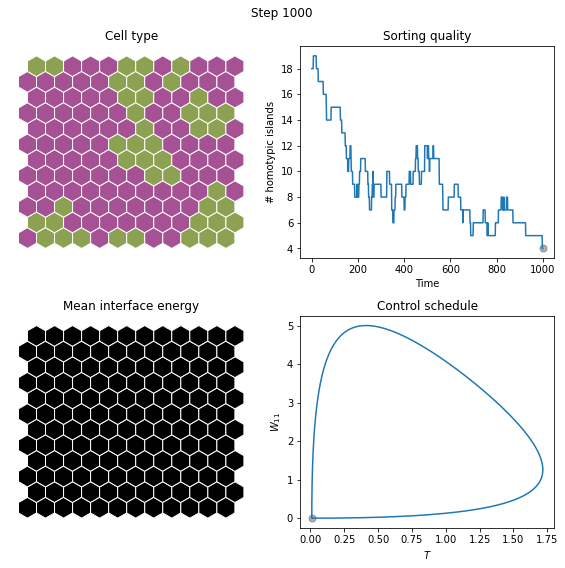

In [14]:
tf = lambda step: f"Step {step}"
animate_sim_layout(
    fpath=anim_fpath,
    X=X,
    c_t=c_t,
    Ec_t=E_cell_t.to_py(),
    T_t=T_t.to_py(),
    W11_t=W11_t.to_py(),
    ncc_t=ncc_t,
    ctype_clr=ctype_clr,
    title_fun=tf,
    n_frames=100,
    fps=20,
    prog_every=10,
)

---

In [15]:
# on_edge = cx.get_outer_idx(nrows, cols=nrows)

# # Locations of cells i and their neighbors j
# X_i = np.atleast_3d(X).transpose(0, 2, 1)
# X_i = np.concatenate([X_i] * AL.shape[1], axis=1)
# X_j = X[AL.to_py()]

# prows = 4
# pcols = 4

# def plot_frame(step):
#     E_cell = E_cell_t[step]
#     c      = c_t[step]
#     clrs   = [cx.viz.rgba2hex(rgba) for rgba in clrs_t[step]]
    
#     fill_args = []
#     for j in range(n):
#         fill_args += [hex_verts[j, :, 0], hex_verts[j, :, 1], clrs[j]]
#     plt.fill(*fill_args)
#     plt.gca().set_title(f"{step=}")

# nplot = prows * pcols
# steps = np.linspace(0, nt-1, nplot, dtype=int)
# fig = plt.figure(figsize=(10, 10))
# for i in range(nplot):
#     ax = fig.add_subplot(prows, pcols, i + 1)
#     ax.axis("off")
#     ax.set_aspect("equal")
#     plot_frame(steps[i])

# plt.suptitle("Cell types")
# plt.tight_layout()

In [16]:
# clrs_t = cmap(E_cell_t / E_cell_t.max())

# nplot = prows * pcols
# steps = np.linspace(0, nt-1, nplot, dtype=int)
# fig = plt.figure(figsize=(10, 10))
# for i in range(nplot):
#     ax = fig.add_subplot(prows, pcols, i + 1)
#     ax.axis("off")
#     ax.set_aspect("equal")
#     plot_frame(steps[i])

# plt.suptitle("Adhesive energy")
# plt.tight_layout()